In [1]:
import sys
sys.path.append('../src')

import typing as tp
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from tqdm import tqdm

from imutils import impreprocess, gray2gray3d, make_noised, load_npy, imshow
from data.convolution import convolve
from data.convertation import linrgbf_to_srgbf
from deconv.classic.wiener.wiener import wiener_gray
from deconv.neural.usrnet.predictor import USRNetPredictor
from deconv.neural.dwdn.predictor import DWDNPredictor
from deconv.neural.kerunc.predictor import KerUncPredictor
from services.psf_distorter import PSFDistorter
from metrics import psnr, ssim

plt.gray()

np.random.seed(8)

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

<Figure size 640x480 with 0 Axes>

In [2]:
def _1d_t0_3d(image: np.ndarray) -> np.ndarray:
    return np.dstack([image for _ in range(3)])


def viz(
    image: np.ndarray,
    true_psf: np.ndarray,
    distorted_psf: np.ndarray,
    blurred: np.ndarray,
    blurred_3d: np.ndarray,
    models: dict,
    is_noised: bool,
    is_srgb: bool,
):
    if is_srgb:
        viz_preprocess = lambda image: linrgbf_to_srgbf(_1d_t0_3d(image))
    else:
        viz_preprocess = lambda image: _1d_t0_3d(image)

    blurred_with_distorted_psf = convolve(image, distorted_psf)

    _, ax = plt.subplots(3, 4, figsize=(12, 10))

    ax[0, 0].imshow(true_psf)
    ax[0, 0].axis('off')
    ax[0, 0].set_title('True PSF')

    ax[0, 1].imshow(distorted_psf)
    ax[0, 1].axis('off')
    ax[0, 1].set_title(f'Distorted PSF (SSIM: {ssim(blurred, blurred_with_distorted_psf):.2f})')

    ax[0, 2].imshow(viz_preprocess(blurred))
    ax[0, 2].axis('off')
    ax[0, 2].set_title('Blurred')

    ax[0, 3].imshow(viz_preprocess(image))
    ax[0, 3].axis('off')
    ax[0, 3].set_title(f'Original image')

    noise = 'noise' if is_noised else 'no_noise'
    for i, model_name in enumerate(models.keys()):
        model = models[model_name][noise]
        
        restored = (
            model(blurred_3d, true_psf)[..., 0]
            if model_name in ['usrnet', 'dwdn']
            else model(blurred, true_psf)
        )
        restored = np.clip(restored, 0, 1)
        
        ax[1, i].imshow(viz_preprocess(restored))
        ax[1, i].axis('off')
        ax[1, i].set_title(f'{model_name}\nssim: {ssim(image, restored):.2f}, psnr: {psnr(image, restored):.2f}')
    
        restored = (
            model(blurred_3d, distorted_psf)[..., 0]
            if model_name in ['usrnet', 'dwdn']
            else model(blurred, distorted_psf)
        )
        
        restored = np.clip(restored, 0, 1)
        ax[2, i].imshow(viz_preprocess(restored))
        ax[2, i].axis('off')
        ax[2, i].set_title(f'{model_name}\nssim: {ssim(image, restored):.2f}, psnr: {psnr(image, restored):.2f}')

 
####

def get_image_psf(
    image_path: str,
    psf_path: str,
    crop: bool,
    is_noised: bool,
) -> tp.Tuple[np.array, np.array, np.array, np.array]:
    """Returns GRAY image in specified discretization"""

    image = impreprocess(image_path, crop=crop)
    psf = load_npy(psf_path, key='psf')

    mu = 0
    sigma = 0.01

    # blurred
    blurred = convolve(image, psf)
    blurred_3d = gray2gray3d(blurred)

    if is_noised:
        blurred = make_noised(blurred, mu=mu, sigma=sigma)
        blurred_3d = make_noised(blurred_3d, mu=mu, sigma=sigma)
    
    return image, psf, blurred, blurred_3d

In [3]:
config = OmegaConf.load('../configs/config_viz_cuda.yml')
cm = config.models

models = dict()

models['wiener'] = dict()
models['wiener']['noise'] = lambda image, psf: wiener_gray(image, psf, **cm.wiener_nonblind_noise.noise_params)
models['wiener']['no_noise'] = lambda image, psf: wiener_gray(image, psf, **cm.wiener_nonblind_noise.no_noise_params)

models['kerunc'] = dict()
models['kerunc']['noise'] = KerUncPredictor(**cm.kerunc.noise_params)
models['kerunc']['no_noise'] = KerUncPredictor(**cm.kerunc.no_noise_params)

models['usrnet'] = dict()
models['usrnet']['noise'] = USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.noise_params)
models['usrnet']['no_noise'] = USRNetPredictor(model_path=cm.usrnet.model_path, **cm.usrnet.no_noise_params)

models['dwdn'] = dict()
models['dwdn']['noise'] = DWDNPredictor(model_path=cm.dwdn.model_path, **cm.dwdn.noise_params)
models['dwdn']['no_noise'] = DWDNPredictor(model_path=cm.dwdn.model_path, **cm.dwdn.no_noise_params)


In [4]:
distorter = PSFDistorter()

IS_NOISED = True

## 1 Motion blur

### 1

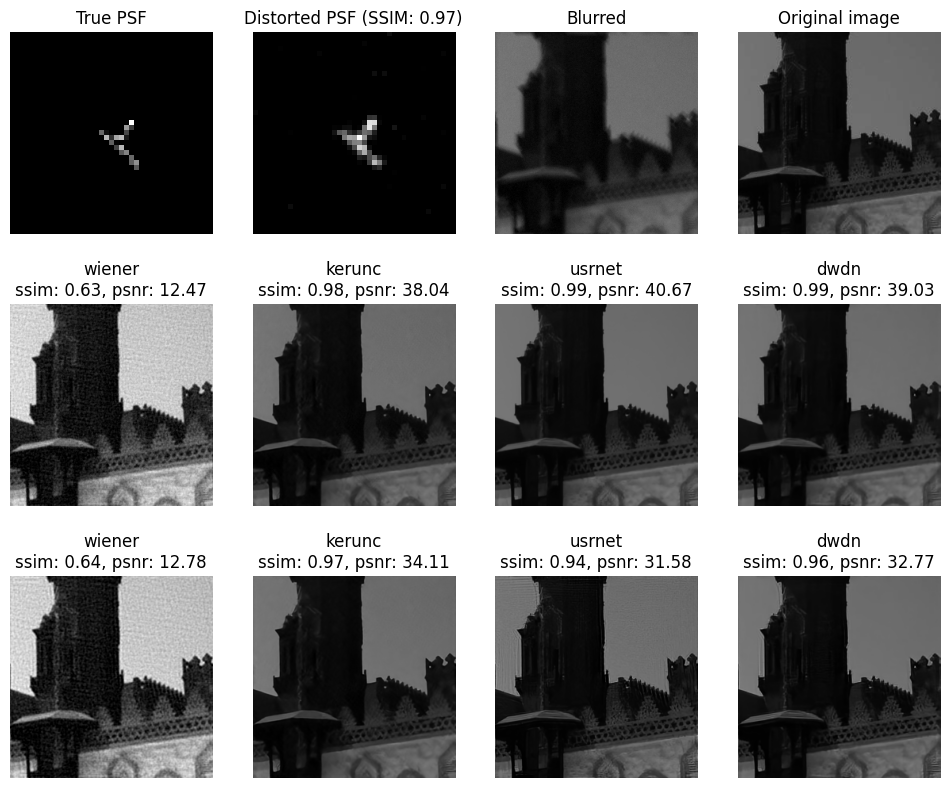

In [5]:
image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_48.png',
    psf_path='../datasets/kernels/motion-blur/processed/synthetic/synthetic-29.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('motion_blur', psf=psf, v_g=0.01, gaus_var=0.8)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=False)

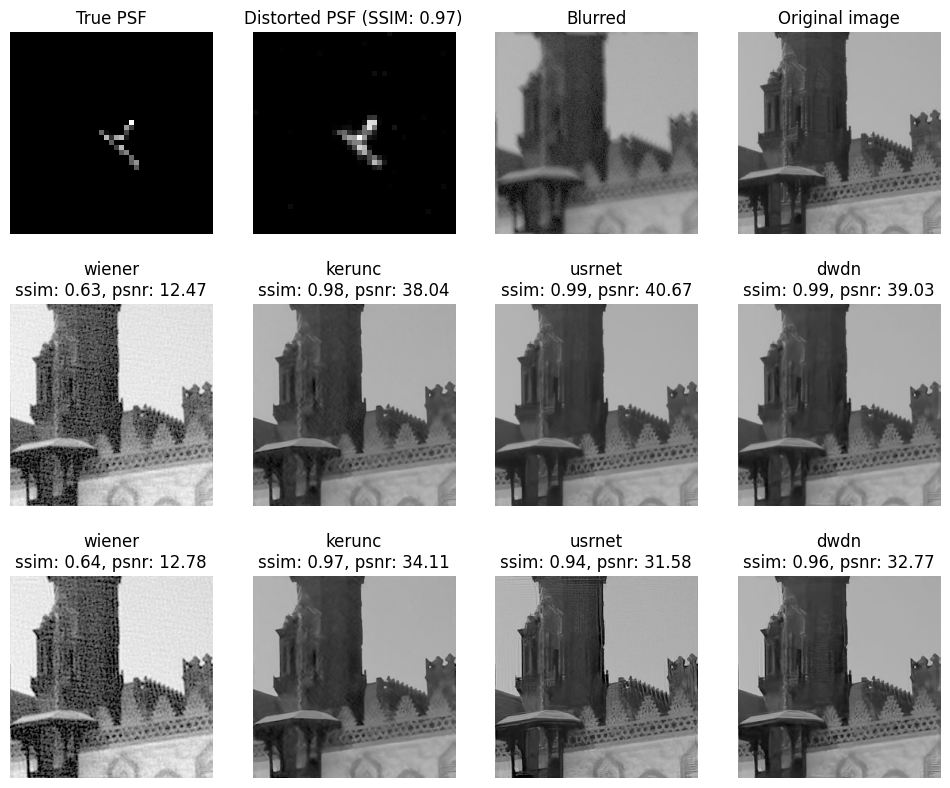

In [6]:
viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

### 2

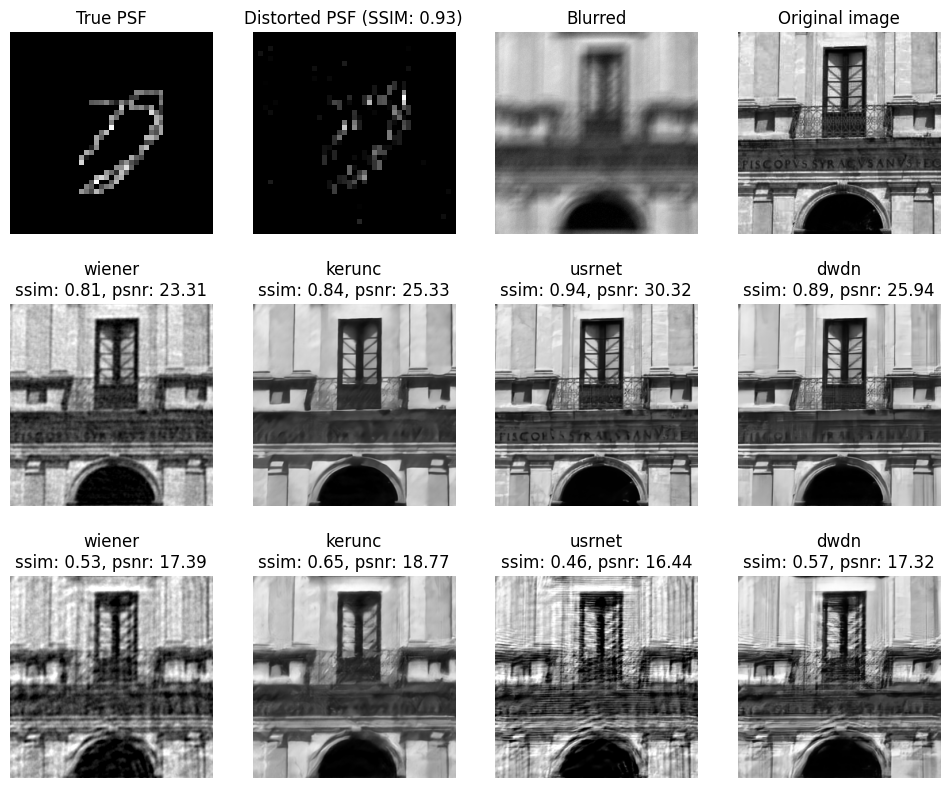

In [7]:
image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_10.png',
    psf_path='../datasets/kernels/motion-blur/processed/synthetic/synthetic-26.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('motion_blur', psf=psf, v_g=0.01, gaus_var=0.8)


viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=False)

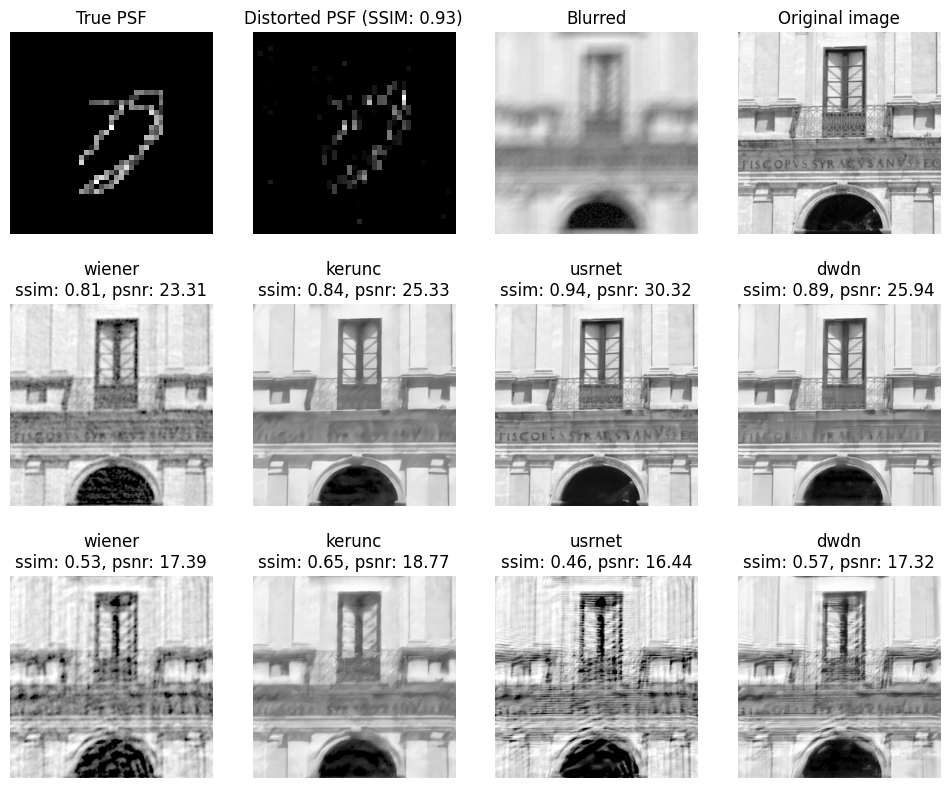

In [8]:
viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

### 3

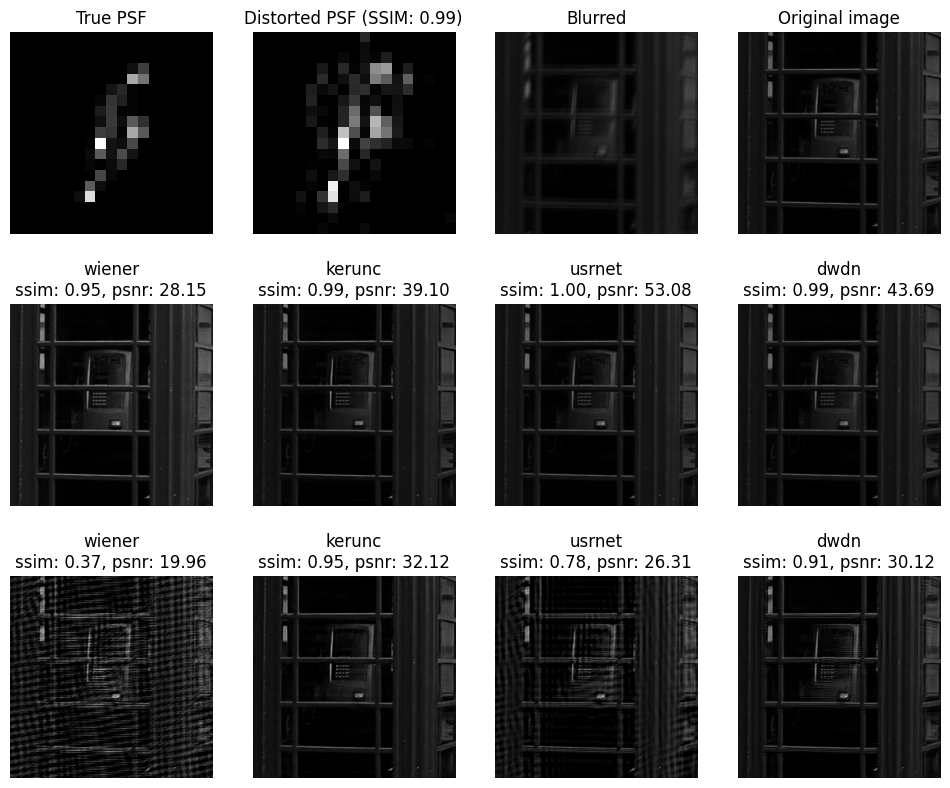

In [9]:
IS_NOISED = False

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_53.png',
    psf_path='../datasets/kernels/motion-blur/processed/Levin/levin-0.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('motion_blur', psf=psf, v_g=0.01, gaus_var=0.8)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=False)

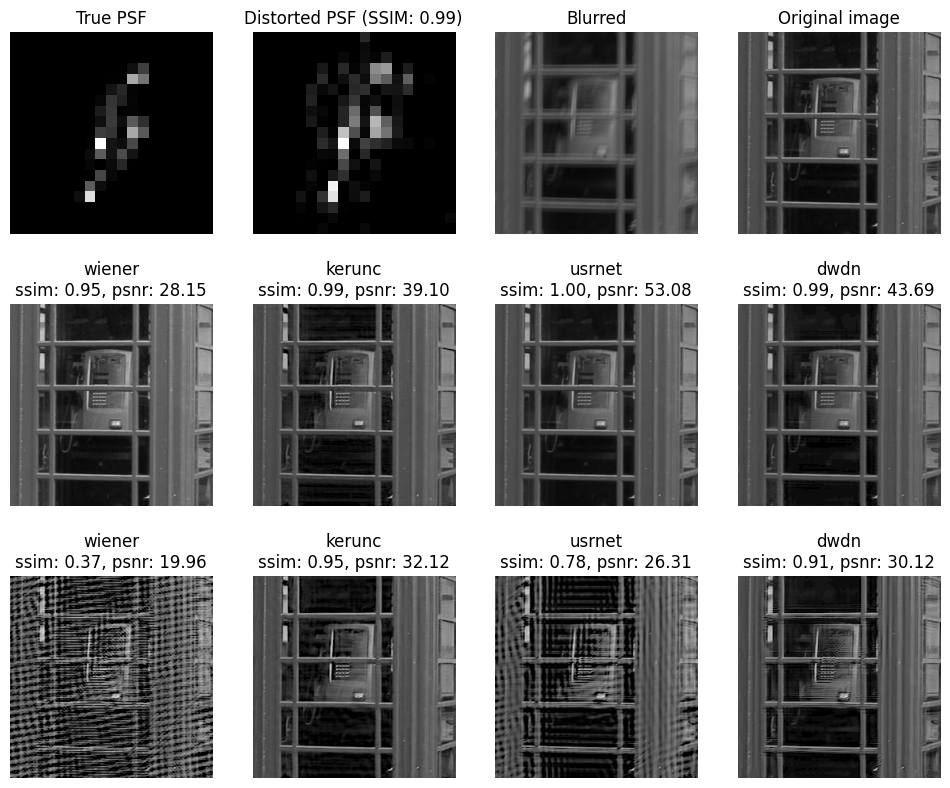

In [10]:
viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

### 4

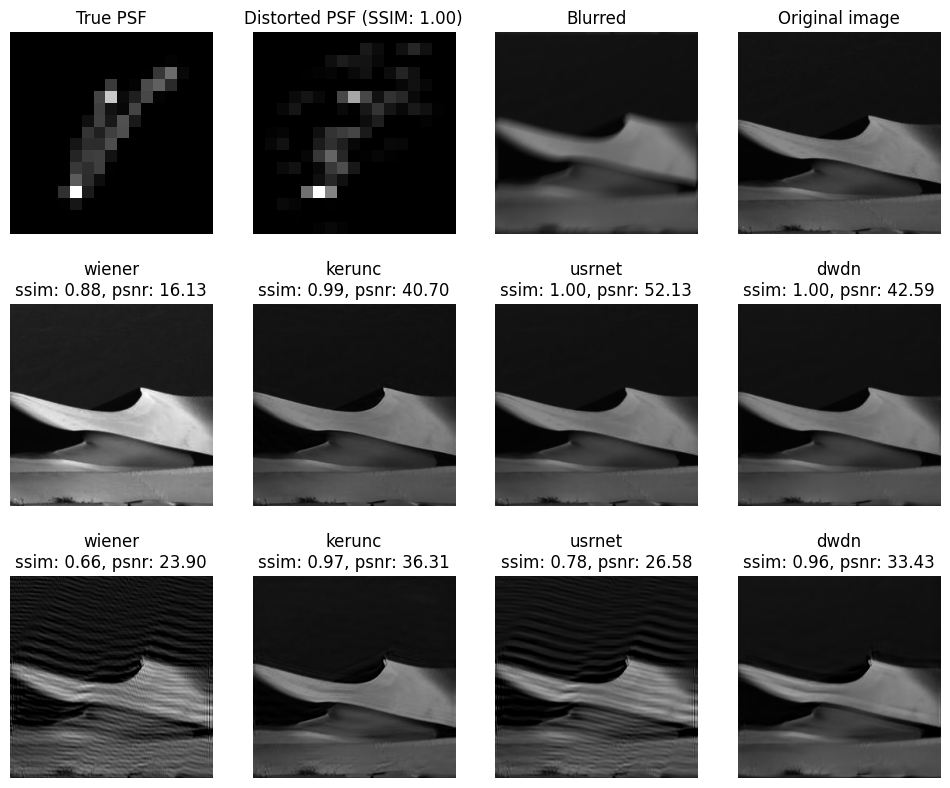

In [11]:
image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_27.png',
    psf_path='../datasets/kernels/motion-blur/processed/Levin/levin-3.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('motion_blur', psf=psf, v_g=0.01, gaus_var=0.8)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=False)

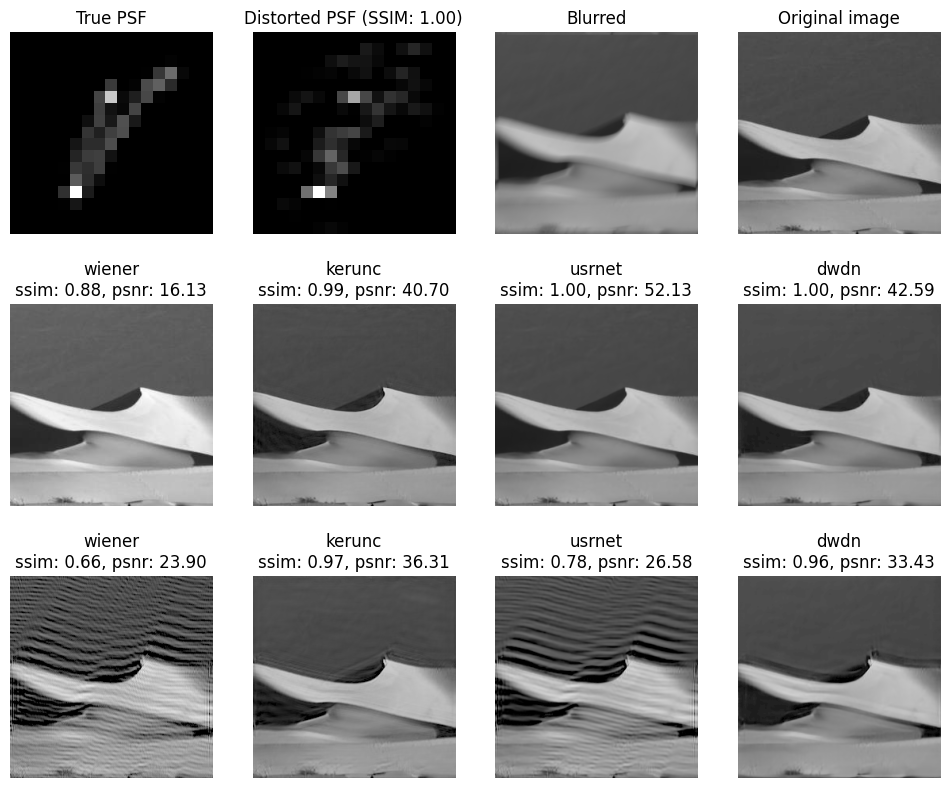

In [12]:
viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

## 2 Gauss blur

### 1

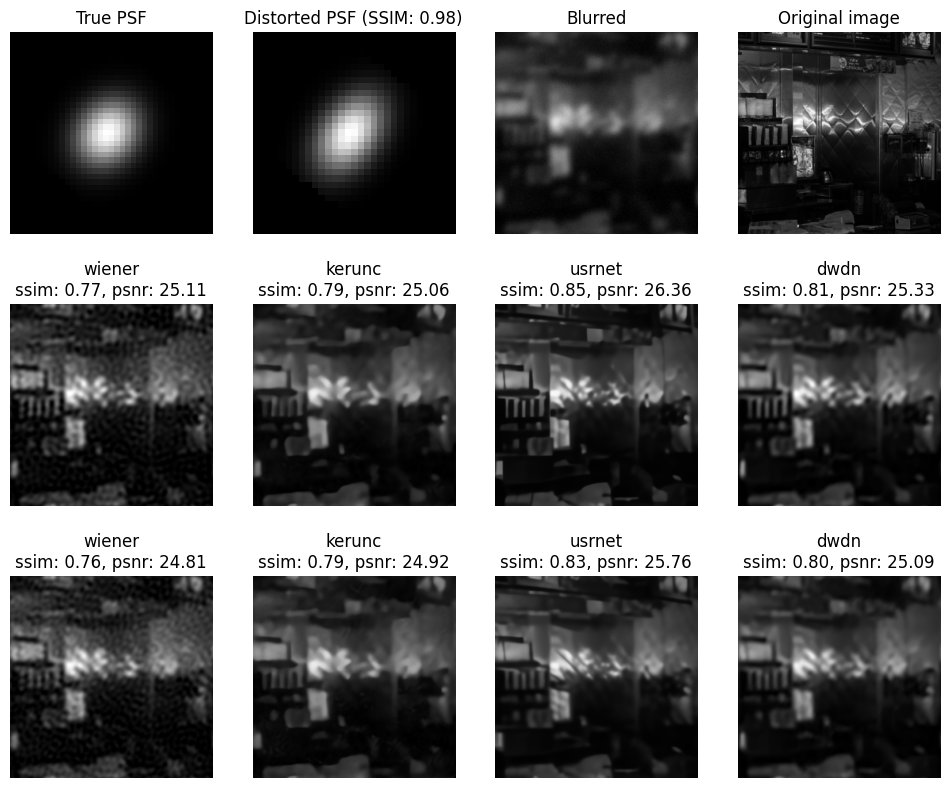

In [15]:
PSF_PATH = '../datasets/kernels/gauss-blur/processed/synthetic/synthetic-0.npy'
IS_NOISED = True

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_28.png',
    psf_path=PSF_PATH,
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('gauss_blur', psf_params=load_npy(PSF_PATH, key='params'), max_delta_sigma=2, max_delta_angle=10)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=False)

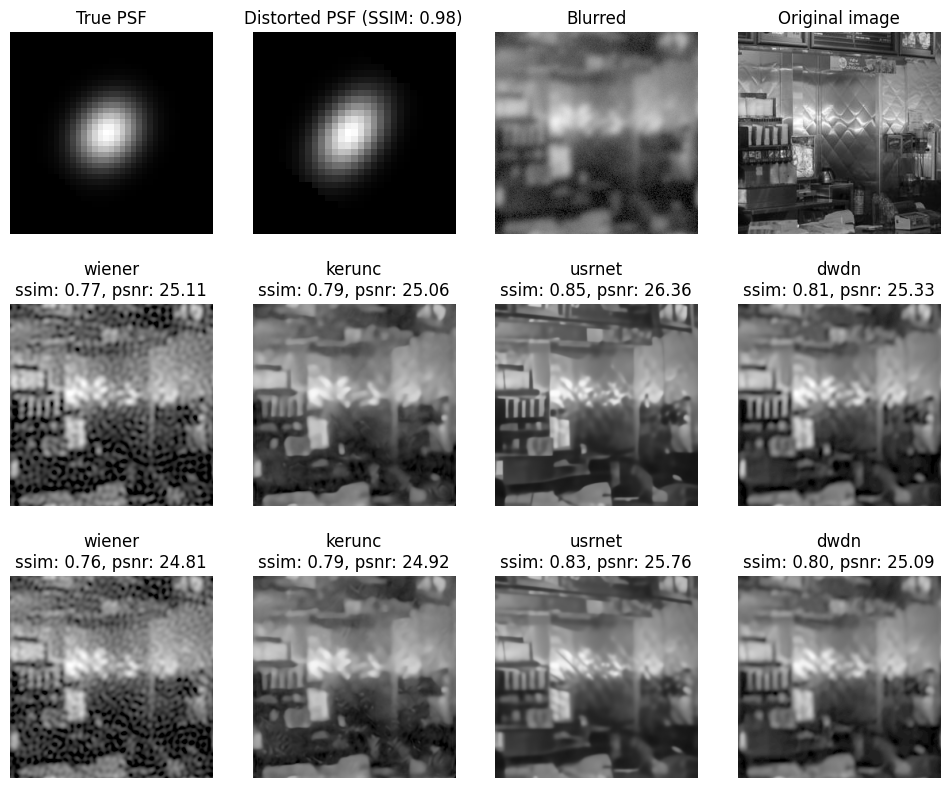

In [16]:
viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

### 2

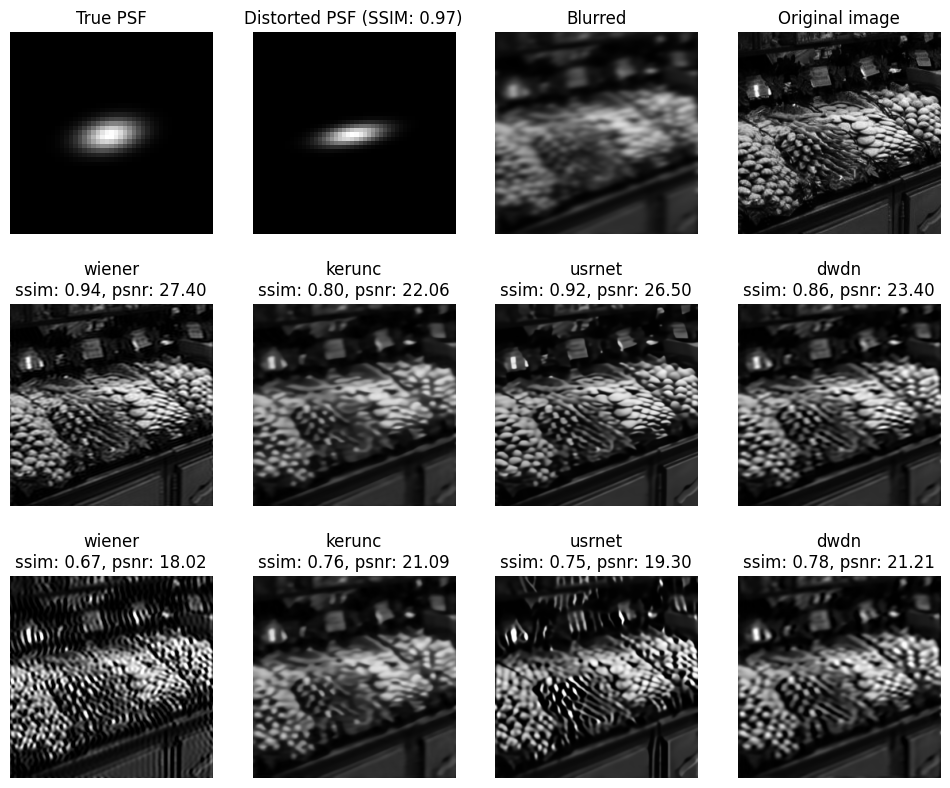

In [17]:
PSF_PATH = '../datasets/kernels/gauss-blur/processed/synthetic/synthetic-2.npy'
IS_NOISED = False

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_16.png',
    psf_path=PSF_PATH,
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('gauss_blur', psf_params=load_npy(PSF_PATH, key='params'), max_delta_sigma=3, max_delta_angle=10)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=False)

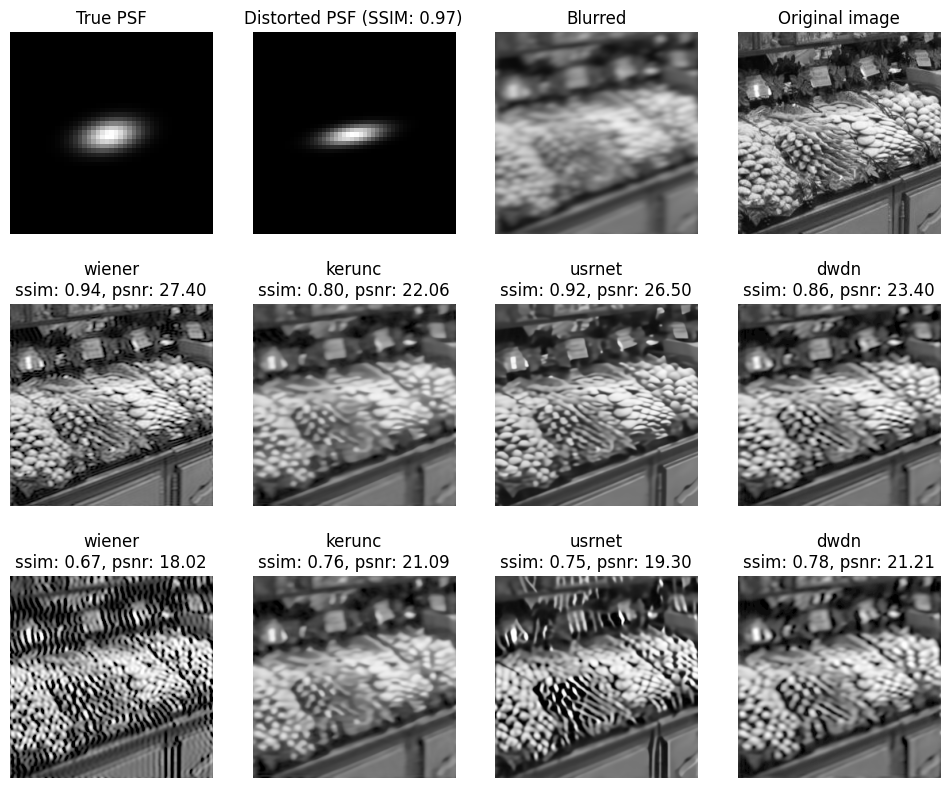

In [18]:
viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

## 3 Eye blur

### 1

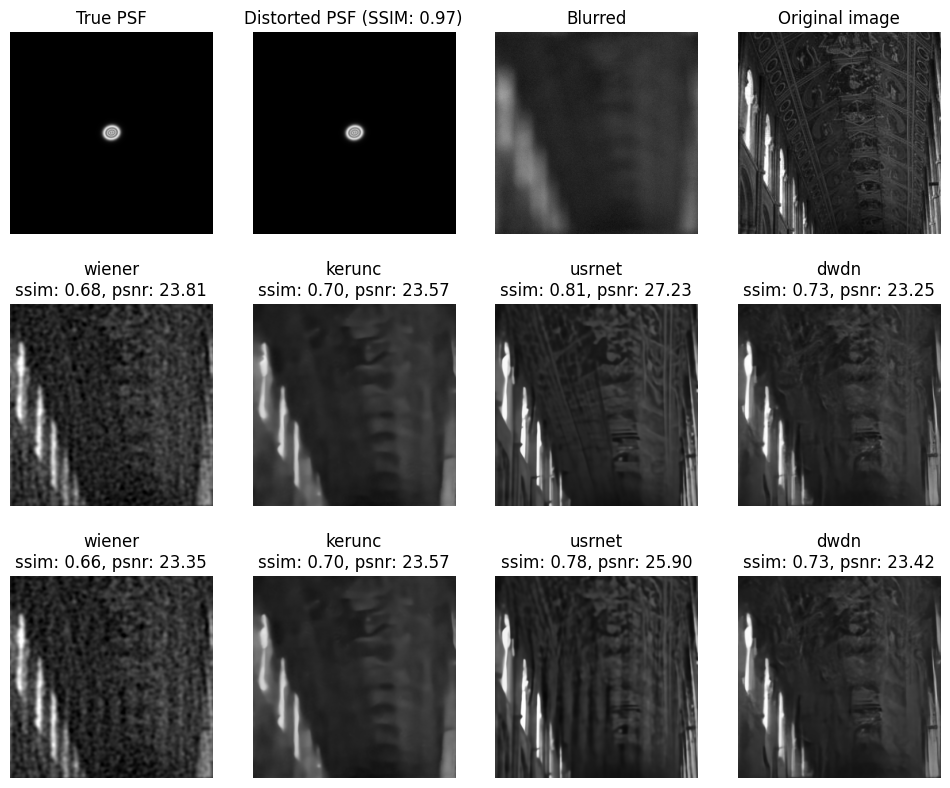

In [19]:
IS_NOISED = True

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_18.png',
    psf_path='../datasets/kernels/eye-psf/processed/synthetic/small-psf-0.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('eye_blur', psf=psf, delta_size=-6)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=False)

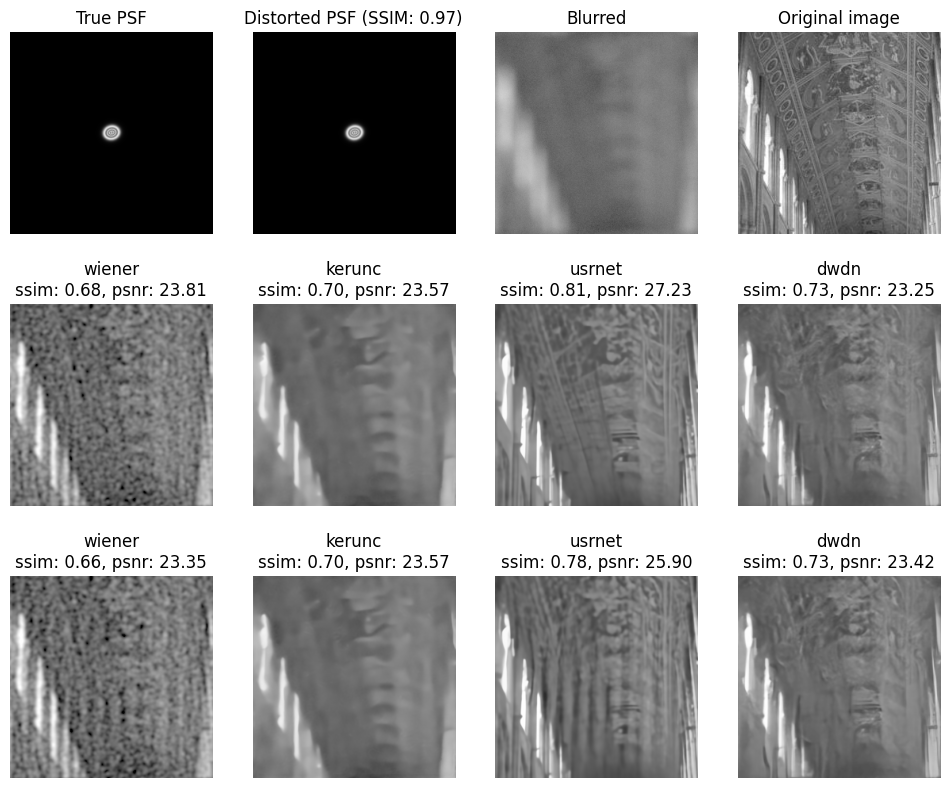

In [20]:
viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

### 2

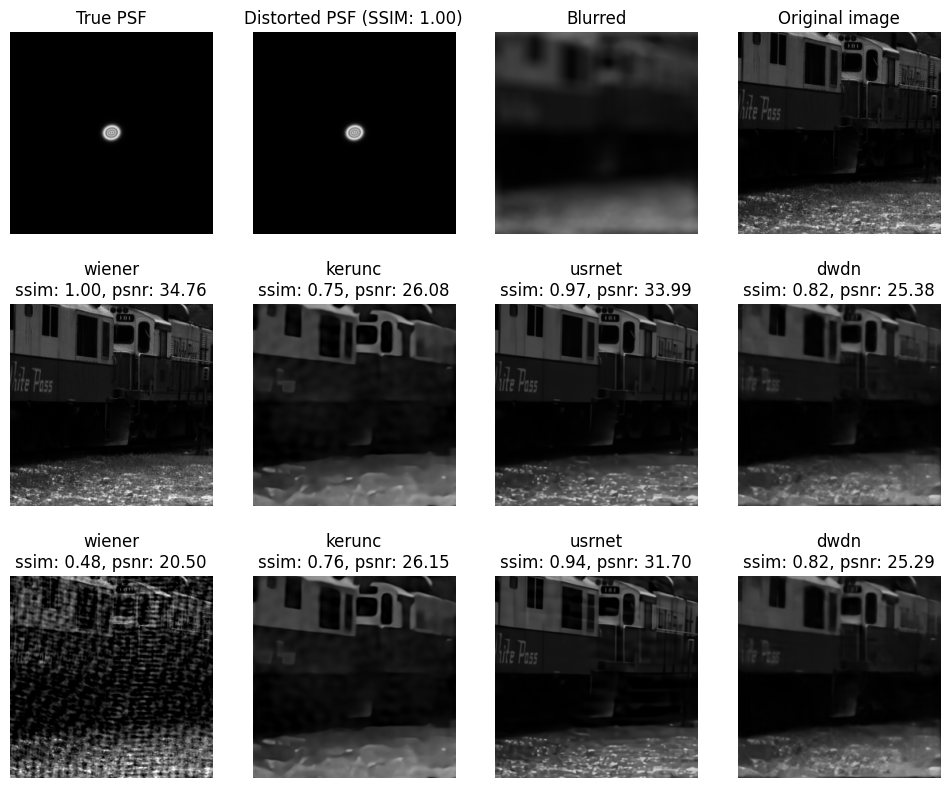

In [21]:
IS_NOISED = False

image, psf, blurred, blurred_3d = get_image_psf(
    image_path='../datasets/gt/Sun-gray/im_65.png',
    psf_path='../datasets/kernels/eye-psf/processed/synthetic/small-psf-0.npy',
    is_noised=IS_NOISED,
    crop=True,
)

psf_distorted = distorter('eye_blur', psf=psf, delta_size=-6)

viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=False)

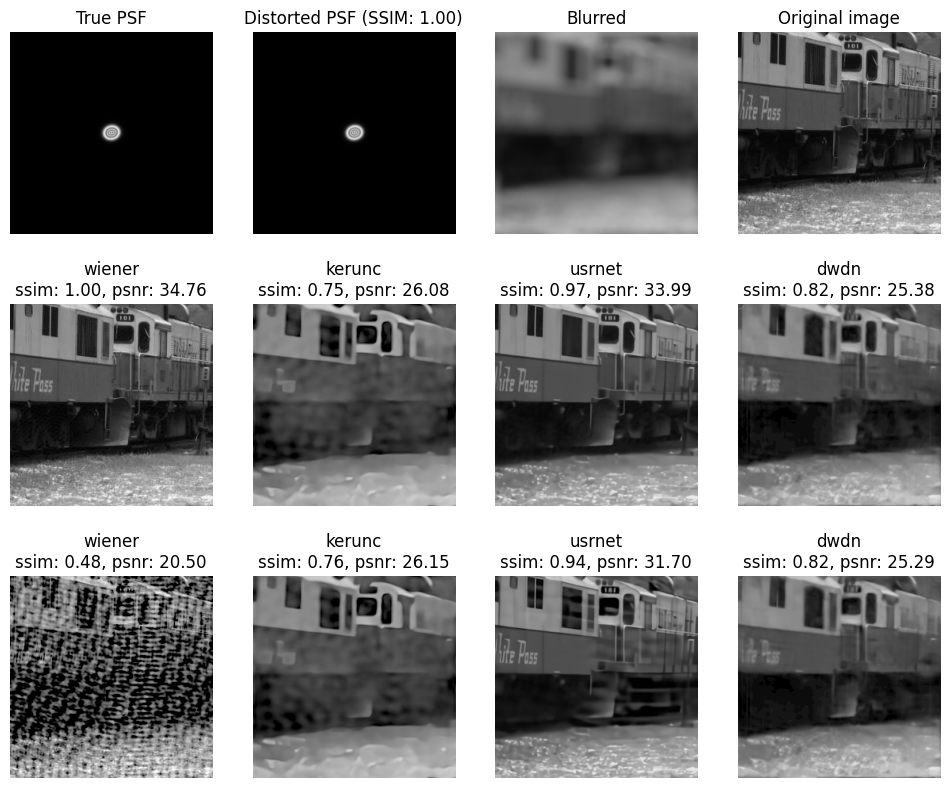

In [22]:
viz(image, psf, psf_distorted, blurred, blurred_3d, models, is_noised=IS_NOISED, is_srgb=True)

## Статистики деградации качества

In [25]:
def eval_robustness(
    models: dict,
    is_noised: bool,
    benchmark_list_path: str = '../datasets/full_dataset.txt',
    noise_mu: float = 0,
    noise_sigma: float = 0.01,
) -> tp.Tuple[dict, dict]:
    
    distorter = PSFDistorter()
    
    dictortion_params = {
        'motion_blur': {'psf': None, 'v_g': 0.01, 'gaus_var': 0.8},
        'gauss_blur': {'psf_params': None, 'max_delta_sigma': 2, 'max_delta_angle': 10},
        'eye_blur': {'psf': None, 'delta_size': -6}
    }
    
    metrics = {
    'ssim': {'motion_blur': [], 'gauss_blur': [], 'eye_blur_small': [], 'eye_blur_medium': [], 'eye_blur_big': []},
    'psnr': {'motion_blur': [], 'gauss_blur': [], 'eye_blur_small': [], 'eye_blur_medium': [], 'eye_blur_big': []},
}
    noised = 'no_noise'
    metrics_true = {}
    metrics_distorted = {}

    for model_name in models.keys():
        metrics_true[model_name] = deepcopy(metrics)
        metrics_distorted[model_name] = deepcopy(metrics)

    with open(benchmark_list_path, 'r+') as file:
        next(file)  # skip line with headers
        for line in tqdm(file):
            blur_type, blur_dataset, kernel_path, image_dataset, image_path = line.strip().split(',')
            image_path = '../' + image_path
            kernel_path = '../' + kernel_path

            image = impreprocess(image_path, crop=True)
            psf_true =  load_npy(kernel_path, key='psf')
            blurred = convolve(image, psf_true)
            blurred_3d = gray2gray3d(blurred)
            
            if is_noised:
                blurred = make_noised(blurred, mu=noise_mu, sigma=noise_sigma)
                blurred_3d = make_noised(blurred_3d, mu=noise_mu, sigma=noise_sigma)
                noised = 'noise' 

            if blur_type == 'motion_blur' or blur_type == 'eye_blur':
                dictortion_params[blur_type]['psf'] = psf_true
            elif blur_type == 'gauss_blur':
                dictortion_params[blur_type]['psf_params'] = load_npy(kernel_path, key='params')

            psf_distorted = distorter(blur_type, **dictortion_params[blur_type])

            if blur_type == 'eye_blur':
                for size in ['small', 'medium', 'big']:
                    if size in kernel_path:
                        blur_type = blur_type + '_' + size

            for i, model_name in enumerate(models.keys()):
                model = models[model_name][noised]

                restored = (
                    model(blurred_3d, psf_true)[..., 0]
                    if model_name in ['usrnet', 'dwdn']
                    else model(blurred, psf_true)
                )

                metrics_true[model_name]['ssim'][blur_type].append(ssim(image, restored))
                metrics_true[model_name]['psnr'][blur_type].append(psnr(image, restored))

                restored = (
                    model(blurred_3d, psf_distorted)[..., 0]
                    if model_name in ['usrnet', 'dwdn']
                    else model(blurred, psf_distorted)
                )

                metrics_distorted[model_name]['ssim'][blur_type].append(ssim(image, restored))
                metrics_distorted[model_name]['psnr'][blur_type].append(psnr(image, restored))
    
    return metrics_true, metrics_distorted
    

In [26]:
def set_medians(data, ax, medians):
    pos = range(1, len(data)+1)
    for tick, label in zip(pos, ax.get_xticklabels()):
        ax.text(pos[tick-1], medians[tick-1], str(medians[tick-1]), 
                horizontalalignment='center', size='small', color='black', weight='semibold')

        
def draw_boxplot(metric_name: str, model_name: str, metrics_true: dict, metrics_distorted: dict, idx: int, idy: int):
    blur_types = metrics_true[model_name]['psnr'].keys()
    data = []
    for blur_type in blur_types:
        data.append(divide_lists(metrics_distorted[model_name][metric_name][blur_type], metrics_true[model_name][metric_name][blur_type]))
    medians = [np.round(np.median(d), 2) for d in data]
    axs[idx, idy].boxplot(data)
    if idx == 1:
        axs[idx, idy].set_xticks([i for i in range(1, 6)], blur_types, rotation=45)
    if idy == 0:
        axs[idx, idy].set_ylabel(f"Деградация качества {metric_name.upper()}")
    axs[idx, idy].set_ylim(0.0, 1.8)
    axs[idx, idy].set_title(model_name)
    set_medians(data, axs[idx, idy], medians)

    
def divide_lists(list1: list, list2: list) -> list:
    return [i / j for i, j in zip(list1, list2)]


assert divide_lists([1, 2, 3], [2, 2, 2]) == [0.5, 1.0, 1.5]

### Без шума

In [27]:
metrics_true, metrics_distorted = eval_robustness(models, is_noised=False, benchmark_list_path = '../datasets/full_dataset.txt')

631it [08:25,  1.42it/s]WARNING:root:PSF has sum more than 1. Normed
634it [08:26,  1.80it/s]WARNING:root:PSF has sum more than 1. Normed
636it [08:27,  1.95it/s]WARNING:root:PSF has sum more than 1. Normed
721it [09:11,  1.93it/s]WARNING:root:PSF has sum more than 1. Normed
727it [09:14,  2.01it/s]WARNING:root:PSF has sum more than 1. Normed
791it [09:47,  1.87it/s]WARNING:root:PSF has sum more than 1. Normed
795it [09:49,  2.02it/s]WARNING:root:PSF has sum more than 1. Normed
1162it [12:52,  1.50it/s]


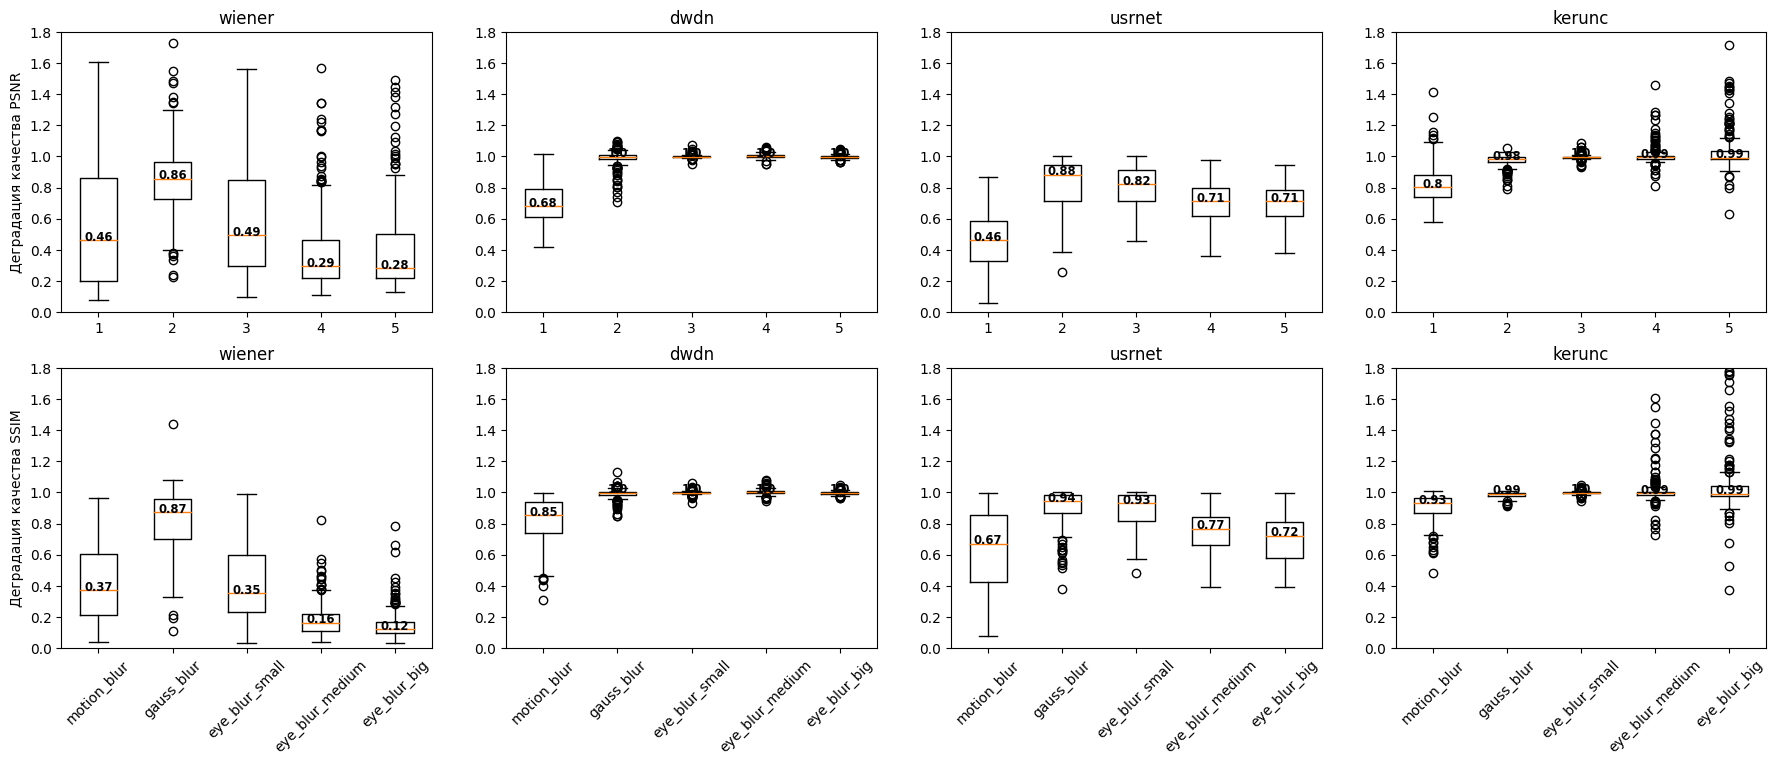

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(22, 8))

draw_boxplot('psnr', 'wiener', metrics_true, metrics_distorted, idx=0, idy=0)
draw_boxplot('psnr', 'dwdn', metrics_true, metrics_distorted, idx=0, idy=1)
draw_boxplot('psnr', 'usrnet', metrics_true, metrics_distorted, idx=0, idy=2)
draw_boxplot('psnr', 'kerunc', metrics_true, metrics_distorted, idx=0, idy=3)

draw_boxplot('ssim', 'wiener', metrics_true, metrics_distorted, idx=1, idy=0)
draw_boxplot('ssim', 'dwdn', metrics_true, metrics_distorted, idx=1, idy=1)
draw_boxplot('ssim', 'usrnet', metrics_true, metrics_distorted, idx=1, idy=2)
draw_boxplot('ssim', 'kerunc', metrics_true, metrics_distorted, idx=1, idy=3)

### С шумом:

In [29]:
metrics_true, metrics_distorted = eval_robustness(models, is_noised=True, benchmark_list_path = '../datasets/full_dataset.txt')

631it [08:27,  1.40it/s]WARNING:root:PSF has sum more than 1. Normed
632it [08:28,  1.55it/s]WARNING:root:PSF has sum more than 1. Normed
634it [08:29,  1.79it/s]WARNING:root:PSF has sum more than 1. Normed
635it [08:29,  1.87it/s]WARNING:root:PSF has sum more than 1. Normed
636it [08:30,  1.92it/s]WARNING:root:PSF has sum more than 1. Normed
723it [09:15,  1.97it/s]WARNING:root:PSF has sum more than 1. Normed
724it [09:15,  1.91it/s]WARNING:root:PSF has sum more than 1. Normed
726it [09:16,  1.98it/s]WARNING:root:PSF has sum more than 1. Normed
791it [09:50,  1.85it/s]WARNING:root:PSF has sum more than 1. Normed
1162it [12:58,  1.49it/s]


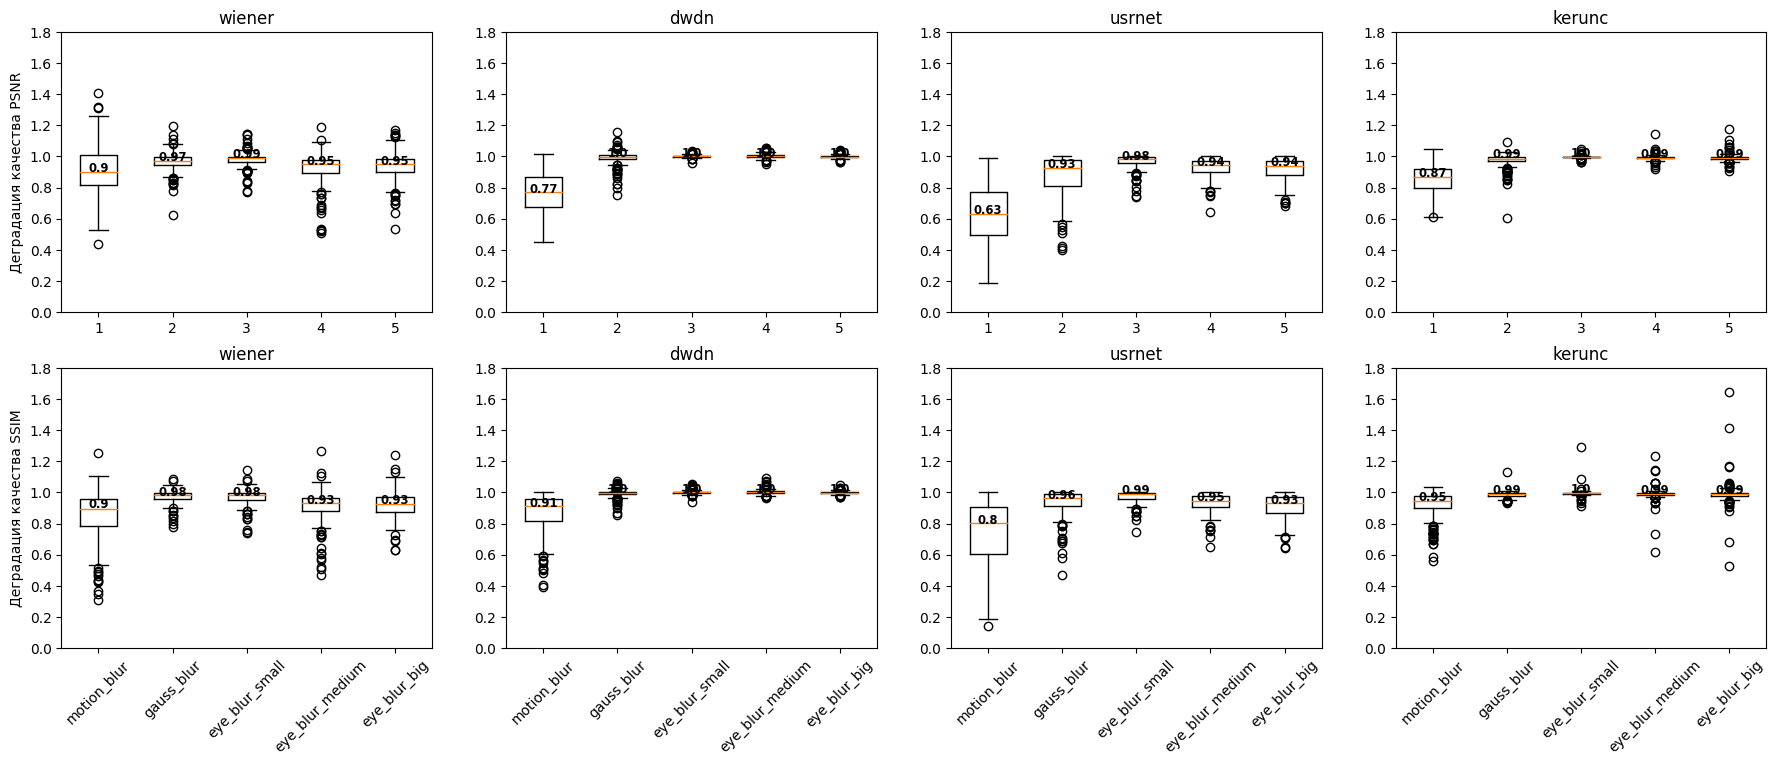

In [30]:
fig, axs = plt.subplots(2, 4, figsize=(22, 8))

draw_boxplot('psnr', 'wiener', metrics_true, metrics_distorted, idx=0, idy=0)
draw_boxplot('psnr', 'dwdn', metrics_true, metrics_distorted, idx=0, idy=1)
draw_boxplot('psnr', 'usrnet', metrics_true, metrics_distorted, idx=0, idy=2)
draw_boxplot('psnr', 'kerunc', metrics_true, metrics_distorted, idx=0, idy=3)

draw_boxplot('ssim', 'wiener', metrics_true, metrics_distorted, idx=1, idy=0)
draw_boxplot('ssim', 'dwdn', metrics_true, metrics_distorted, idx=1, idy=1)
draw_boxplot('ssim', 'usrnet', metrics_true, metrics_distorted, idx=1, idy=2)
draw_boxplot('ssim', 'kerunc', metrics_true, metrics_distorted, idx=1, idy=3)